# Plotting Scripts
Copyright (c) 2025 University of Salerno SPDX-License-Identifier: Apache-2.0

Run this whole Jupyter to produce the paper plots.

### Initialization

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from rdkit import Chem
import os
import sys
import networkx as nx
from tqdm import tqdm
import subprocess

sns.set_theme(style="whitegrid")

In [2]:
# time in ms, memory in bytes
class MBSMParser:
  def __init__(self, out):
    self.lines = [line.strip() for line in out.split('\n')]
    self.parse()
  
  def parseMemory(self, value, unit):
    value = float(value)
    if unit == 'B':
      return value
    elif unit == 'KB':
      return value * 1024
    elif unit == 'MB':
      return value * 1024 * 1024
    elif unit == 'GB':
      return value * 1024 * 1024 * 1024
  
  def parseGPUStats(self, start):
    for i in range(1, 6):
      line = self.lines[start + i]
      if line.startswith('Data signature time'):
        self.data_signature_gpu_time = int(line.split(' ')[-2])
      elif line.startswith('Query signature time'):
        self.query_signature_gpu_time = int(line.split(' ')[-2])
      elif line.startswith('Filter time'):
        self.filter_gpu_time = int(line.split(' ')[-2])
      elif line.startswith('Join time'):
        self.join_gpu_time = int(line.split(' ')[-2])
      elif line.startswith('Total time:'):
        self.total_gpu_time = int(line.split(' ')[-2])
      
      

  def parseHostStats(self, start):
    for i in range(1, 6):
      line = self.lines[start + i]
      if line.startswith('Setup Data time'):
        self.setup_data_host_time = int(line.split(' ')[3])
      elif line.startswith('Filter time'):
        self.filter_host_time = int(line.split(' ')[-2])
      elif line.startswith('Mapping time'):
        self.mapping_host_time = int(line.split(' ')[-2])
      elif line.startswith('Join time'):
        self.join_host_time = int(line.split(' ')[-2])
      elif line.startswith('Total time:'):
        self.total_time = int(line.split(' ')[-2])
  
  def parse(self):
    for i, line in enumerate(self.lines):
      if line.startswith('# Query Nodes'):
        self.n_query_nodes = int(line.split(' ')[-1])
      elif line.startswith('# Query Graphs'):
        self.n_query_graphs = int(line.split(' ')[-1])
      elif line.startswith('# Data Nodes'):
        self.n_data_nodes = int(line.split(' ')[-1])
      elif line.startswith('# Data Graphs'):
        self.n_data_graphs = int(line.split(' ')[-1])
      elif line.endswith('B for graph data'):
        self.graph_data_memory = self.parseMemory(line.split(' ')[1], line.split(' ')[2])
      elif line.endswith('B for query data'):
        self.query_data_memory = self.parseMemory(line.split(' ')[1], line.split(' ')[2])
      elif line.endswith('B for candidates'):
        self.candidates_memory = self.parseMemory(line.split(' ')[1], line.split(' ')[2])
      elif line.endswith('B for data signatures'):
        self.data_signatures_memory = self.parseMemory(line.split(' ')[1], line.split(' ')[2])
      elif line.endswith('B for query signatures'):
        self.query_signatures_memory = self.parseMemory(line.split(' ')[1], line.split(' ')[2])
      elif line.startswith('Total allocated memory'):
        self.total_memory = self.parseMemory(line.split(' ')[3], line.split(' ')[4])
      elif line.startswith('# Total candidates:'):
        self.n_total_candidates = int(line.split(' ')[-1].replace('.', ''))
      elif line.startswith('# Average candidates:'):
        self.n_avg_candidates = int(line.split(' ')[-1].replace('.', ''))
      elif line.startswith('# Median candidates:'):
        self.n_median_candidates = int(line.split(' ')[-1].replace('.', ''))
      elif line.startswith('# Zero candidates:'):
        self.n_zero_candidates = int(line.split(' ')[-1].replace('.', ''))
      elif line.startswith('# Matches:'):
        self.n_matches = int(line.split(' ')[-1].replace('.', ''))
      elif "Overall GPU Stats" in line:
        self.parseGPUStats(i)
      elif "Overall Host Stats" in line:
        self.parseHostStats(i)

## Section 4

In [4]:
def molToGraph(mol):
  graph = nx.Graph()
  for atom in mol.GetAtoms():
    graph.add_node(atom.GetIdx(),
                   atomic_num=atom.GetAtomicNum(),
                   is_aromatic=atom.GetIsAromatic(),
                   atom_symbol=atom.GetSymbol())
  for bond in mol.GetBonds():
    graph.add_edge(bond.GetBeginAtomIdx(),
                   bond.GetEndAtomIdx(),
                   bond_type=bond.GetBondType())
  return graph

molecules = []
patterns = []

with open('./data/data.smarts') as f:
  for line in tqdm(f):
    mol = Chem.MolFromSmiles(line.strip())
    graph = molToGraph(mol)
    molecules.append(graph)

with open('./data/query.smarts') as f:
  for line in tqdm(f):
    mol = Chem.MolFromSmarts(line.strip())
    graph = molToGraph(mol)
    patterns.append(graph)


0it [00:00, ?it/s]

5563it [00:02, 2178.12it/s]


KeyboardInterrupt: 

### Histogram Nodes Degree

In [5]:
degree_df = pd.DataFrame(columns=['Degree', 'Type'])

query_degrees = []
for graph in molecules:
  for node in graph.nodes:
    query_degrees.append(graph.degree(node))

data_degrees = []
for graph in patterns:
  for node in graph.nodes:
    data_degrees.append(graph.degree(node))

query_df = pd.DataFrame(query_degrees, columns=['Degree'])
query_df['Type'] = 'Pattern'

data_df = pd.DataFrame(data_degrees, columns=['Degree'])
data_df['Type'] = 'Molecule'

degree_df = pd.concat([query_df, data_df])

del query_degrees, data_degrees, query_df, data_df


Number of query graphs with degree > 4: 0
Number of data graphs with degree > 4: 18


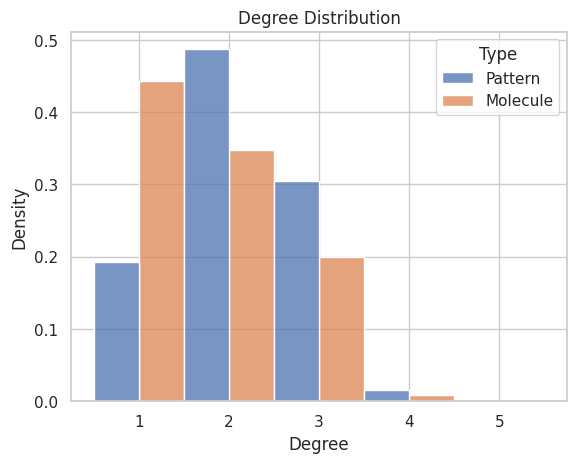

In [ ]:
g = sns.histplot(degree_df, x='Degree', hue='Type', discrete=True, common_norm=False, stat='density', multiple='dodge', binwidth=0.7, element='bars')
g.title.set_text('Degree Distribution')

## Section 6 (Experimental Evaluation)

In [3]:
exec_path = "./build/mbsm"
exec_args = ["-Q", "./data/MBSM/query.dat", "-D", "./data/MBSM/data.dat", "-c", "query"]

outputs_find_all = []


for i in range(8):
  curr_args = exec_args + ["--find-all", "-i", f"{i}"]
  print(f"Running {exec_path} {' '.join(curr_args)}")
  out = subprocess.run([exec_path] + curr_args, check=True, stdout=subprocess.PIPE)
  out = out.stdout.decode('utf-8')
  outputs_find_all.append(out)

best_idx = 3

print(f"Running {exec_path} {' '.join(exec_args)} -i {best_idx}")
output_find_first = subprocess.run([exec_path] + exec_args + ["-i", f"{best_idx}"], check=True, stdout=subprocess.PIPE).stdout.decode('utf-8')

Running ./build/mbsm -Q ./data/MBSM/query.dat -D ./data/MBSM/data.dat -c query --find-all -i 0


Running ./build/mbsm -Q ./data/MBSM/query.dat -D ./data/MBSM/data.dat -c query --find-all -i 1
Running ./build/mbsm -Q ./data/MBSM/query.dat -D ./data/MBSM/data.dat -c query --find-all -i 2
Running ./build/mbsm -Q ./data/MBSM/query.dat -D ./data/MBSM/data.dat -c query --find-all -i 3
Running ./build/mbsm -Q ./data/MBSM/query.dat -D ./data/MBSM/data.dat -c query --find-all -i 4
Running ./build/mbsm -Q ./data/MBSM/query.dat -D ./data/MBSM/data.dat -c query --find-all -i 5
Running ./build/mbsm -Q ./data/MBSM/query.dat -D ./data/MBSM/data.dat -c query --find-all -i 6
Running ./build/mbsm -Q ./data/MBSM/query.dat -D ./data/MBSM/data.dat -c query --find-all -i 7
Running ./build/mbsm -Q ./data/MBSM/query.dat -D ./data/MBSM/data.dat -c query -i 3


In [4]:
results_find_all = []
for out in outputs_find_all:
  out = MBSMParser(out)
  results_find_all.append(out)

result_find_first = MBSMParser(output_find_first)

### Filter VS Join

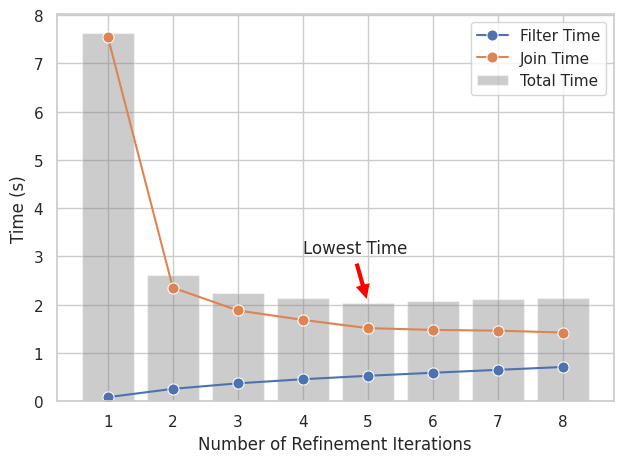

In [5]:
filter_time = [result.filter_gpu_time / 1000 for result in results_find_all]
join_time = [result.join_gpu_time / 1000 for result in results_find_all]

# Create a DataFrame
iterations = list(range(1, len(filter_time) + 1))
data = pd.DataFrame({
    'Iterations': iterations,
    'Filter Time': filter_time,
    'Join Time': join_time
})

# Calculate total time
data['Total Time'] = data['Filter Time'] + data['Join Time']

# Melt the DataFrame to long format
data_melted = data.melt(id_vars='Iterations', value_vars=['Filter Time', 'Join Time'], var_name='Type', value_name='Time')

# Create the line plot
sns.lineplot(data=data_melted, x='Iterations', y='Time', hue='Type', marker='o', markersize=8)

# Add the total time bars
plt.bar(data['Iterations'], data['Total Time'], color='gray', alpha=0.4, label='Total Time')

# Add labels and title
plt.xlabel('Number of Refinement Iterations')
plt.ylabel('Time (s)')

# get the lowest bar and add a label to mark that is the lowest, add also an arrow
lowest_bar = min(data['Total Time'])
plt.annotate('Lowest Time', xy=(data['Iterations'][data['Total Time'].idxmin()], lowest_bar),
             xytext=(data['Iterations'][data['Total Time'].idxmin()] - 1, lowest_bar + lowest_bar * .5),
             arrowprops=dict(facecolor='red', shrink=0.05))


# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.savefig('./out/plots/filter_join_time.pdf')
plt.show()

### Number of Candidates

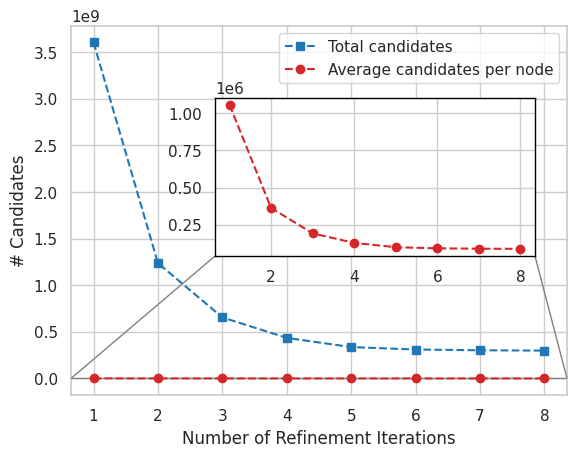

In [6]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

total_candidates = [result.n_total_candidates for result in results_find_all]
avg_candidates = [result.n_avg_candidates for result in results_find_all]
median_candidates = [result.n_median_candidates for result in results_find_all]

# Create a DataFrame
iterations = list(range(1, len(total_candidates) + 1))
data = pd.DataFrame({
    'Iterations': iterations,
    'Total Candidates': total_candidates,
    'Average Candidates': avg_candidates,
    'Median Candidates': median_candidates,
})

# Create the line plot
fig, ax1 = plt.subplots()

ax1.set_ylabel('# Candidates')
ax1.set_xlabel('Number of Refinement Iterations')
ax1.plot(iterations, total_candidates, marker='s', linestyle='dashed', color='tab:blue', label='Total candidates')
ax1.plot(iterations, avg_candidates, marker='o', linestyle='dashed', color='tab:red', label='Average candidates per node')

# create inset axes to show the average candidates
ax2 = fig.add_axes([0.35, 0.4, 0.5, 0.33])
ax2.plot(iterations, avg_candidates, marker='o', linestyle='dashed', color='tab:red')
# set bold border
for spine in ax2.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)
    

mark_inset(ax1, ax2, loc1=3, loc2=4, fc="none", ec="0.5")


ax1.legend(loc='upper right')

# Show the plot
fig.savefig('./out/plots/candidates_vs_filter_time.pdf')
fig.show()

### Comparison Against SOTA

In [7]:
sota_df = pd.DataFrame(columns=['benchmark','total_time','first_solution_time','matches',])
benchmarks = ['VF3', 'GSI', 'CuTS']

best_result_find_all: MBSMParser = results_find_all[best_idx]

sota_df.loc[len(sota_df)] = ['MBSM', best_result_find_all.total_time / 1000, result_find_first.total_time / 1000, results_find_all[3].n_matches]

for b in benchmarks:
  benchmark = b
  total_time = 0
  first_solution_time = 0
  matches = 0
  with open(f'./out/{b}/{b}.txt') as f:
    for line in f:
      if line.startswith('Total time (s):'):
        total_time = float(line.split(' ')[-1])
      elif line.startswith('First match time (s):'):
        first_solution_time = float(line.split(' ')[-1])
      elif line.startswith('Total matches:'):
        matches = int(line.split(' ')[-1].replace(',', ''))
      if first_solution_time == total_time:
        first_solution_time = 0
  sota_df.loc[len(sota_df)] = [benchmark, total_time, first_solution_time, matches]
  
sota_df['throughput'] = sota_df['matches'] / sota_df['total_time']
  

#### Time

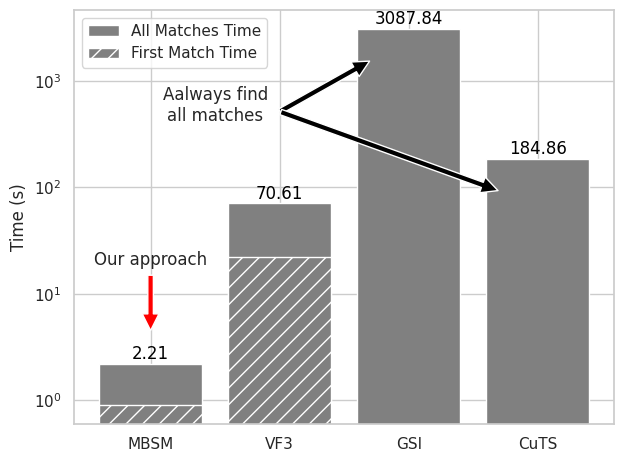

In [8]:
import matplotlib.ticker as ticker
# set gray palette with 3 colors
fig, axs = plt.subplots()

axs.bar(sota_df['benchmark'], sota_df['total_time'], color=['gray', 'gray', 'gray'])
axs.bar(sota_df['benchmark'], sota_df['first_solution_time'], hatch='//', color=['gray', 'gray', 'gray'])

positions = []
for i, row in sota_df.iterrows():
    if row['first_solution_time'] == 0:
        positions.append((i, row['total_time']))

# Annotate the text only once
if positions:
    first_position = positions[0]
    axs.text(first_position[0] - 1.5, first_position[1] / 8, 
             'Aalways find\nall matches', 
             ha='center', va='bottom')  # Center the text horizontally and align it vertically at the bottom

    # Create arrows for all positions
    for pos in positions:
        axs.annotate('', 
                     xy=(pos[0] - .3, pos[1] / 2), 
                     xytext=(first_position[0] - 1, first_position[1] / 6),  # Point to the same text position
                     arrowprops=dict(facecolor='black', shrink=0.005))



axs.annotate("Our approach", 
             xy=(0, sota_df.loc[0, 'total_time'] + 2), 
             xytext=(0, sota_df.loc[0, 'total_time'] + 15), 
             ha='center', va='bottom',  # Center the text horizontally and align it vertically at the bottom
             arrowprops=dict(facecolor='red', shrink=0.05))

# write the time on top of each bar
for i, row in sota_df.iterrows():
  axs.text(i, row['total_time'] + row['total_time'] * 0.02,
           f'{row["total_time"]:.2f}', 
           ha='center', 
           va='bottom', 
           color='black', 
          #  fontweight='bold',
           )

axs.set_yscale('log', base=10, subs=[2, 3, 4, 5, 6, 7, 8, 9])
axs.set_ylabel('Time (s)')
axs.set_xlabel('')

axs.legend(['All Matches Time', 'First Match Time'], loc='upper left')
fig.tight_layout()
fig.savefig('./out/plots/sota_time.pdf')
fig.show()

#### Throughput
Matches per second

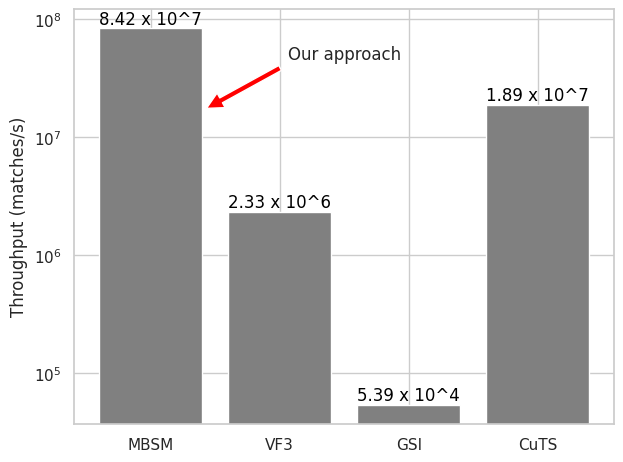

In [9]:
fig, axs = plt.subplots()

axs.bar(sota_df['benchmark'], sota_df['throughput'], color=['gray', 'gray', 'gray'])

axs.annotate("Our approach", 
             xy=(0.4, sota_df.loc[0, 'throughput'] - sota_df.loc[0, 'throughput'] * 0.8), 
             xytext=(1.5, sota_df.loc[0, 'throughput'] - sota_df.loc[0, 'throughput'] * 0.5), 
             ha='center', va='bottom',  # Center the text horizontally and align it vertically at the bottom
             arrowprops=dict(facecolor='red', shrink=0.05))

# write the time on top of each bar
for i, row in sota_df.iterrows():
  thorughput_string = f'{row["throughput"]:.2e}'
  thorughput_string = thorughput_string.replace('e+0', ' x 10^').replace('e+', ' x 10^').replace('e-0', ' / 10^').replace('e-', ' / 10^')
  axs.text(i, row['throughput'] + row['throughput'] * 0.005,
           thorughput_string,
           ha='center', 
           va='bottom', 
           color='black', 
          #  fontweight='bold',
           )

axs.set_ylabel('Throughput (matches/s)')
axs.set_xlabel('')
axs.set_yscale('log', base=10, subs=[2, 3, 4, 5, 6, 7, 8, 9])

fig.savefig('./out/plots/sota_throughput.pdf')
fig.tight_layout()
fig.show()